# Redes Neuronales - Practica 2

### Gozde Yazganoglu

Cargando las Librerías

In [1]:
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from aux_func import show_history, r2_keras


2022-12-21 18:31:52.245955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Utilizamos siguientes funciones para crear una serie temporal sintética y hacer sus gráficos.

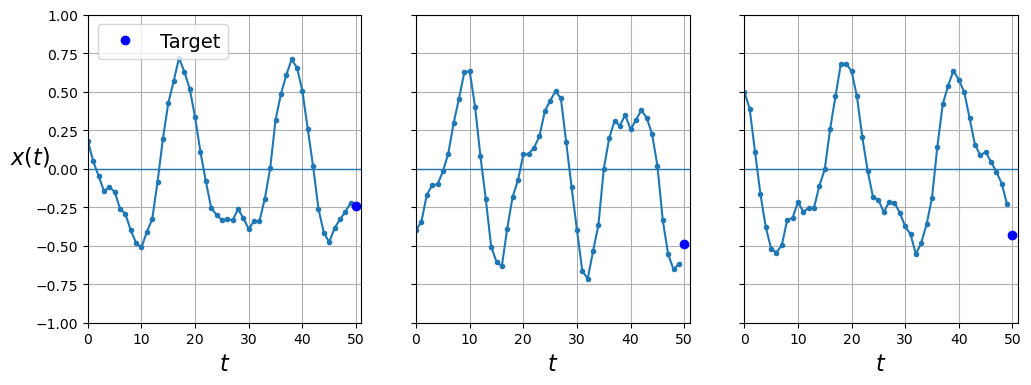

In [2]:

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + noise
    return series[..., np.newaxis].astype(np.float32)


# Generamos train, validation y test
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train_sequence, y_train_sequence = series[:7000, :n_steps], series[:7000, -1]
X_valid_sequence, y_valid_sequence = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test_sequence, y_test_sequence = series[9000:, :n_steps], series[9000:, -1]


# Función para plotear
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")


fig, axes = plt.subplots(nrows=1, ncols=3, sharey='all', figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid_sequence[col, :, 0], y_valid_sequence[col, 0],
                y_label=("$x(t)$" if col == 0 else None),
                legend=(col == 0))
plt.show()

 Seguimos con funciones de loss. MDA es una metrica para evaluar dirección de predicción especialmente en series temporales. Utilizamos también Huber en nuestra perdida customizada.

 -> https://en.wikipedia.org/wiki/Mean_directional_accuracy

 -> https://en.wikipedia.org/wiki/Huber_loss




In [3]:

def mda(y_true, y_pred):
    """Mean Directional Accuracy"""
    d = K.abs(K.sign(y_true[1:] - y_true[:-1]) - (K.sign(y_pred[1:] - y_pred[:-1])))
    s = (1. - d) * (d - 1.) * (d - 2.) / 2.
    return K.mean(s)


def custom_loss_fin(y_true, y_pred):
    h = tf.keras.losses.Huber()
    return h(y_true, y_pred) - mda(y_true, y_pred)


Utilizo LTSM layers para poder predecir las series temporales. Para hacer clasificación usamos en output una capa clasificadora.

In [5]:
input_tensor = Input(shape=(n_steps), dtype='float32')
x_0 = input_tensor
x = tf.expand_dims(x_0, axis=-1)

labels = [0, 1]

for _ in range(5):
    x = LSTM(100, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(x)
x = LSTM(200, activation='tanh', recurrent_activation='relu', return_sequences=False)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation=tf.nn.leaky_relu)(x)
x = layers.Dense(100, activation=tf.nn.leaky_relu)(x)
amount_output = layers.Dense(1, activation=None, name="amount")(x)
class_output = layers.Dense(len(labels), activation= 'softmax', name="updown")(amount_output)

model = Model(inputs=input_tensor, outputs=[amount_output, class_output])
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=[custom_loss_fin, SparseCategoricalCrossentropy],
              loss_weights=[0.01, 0.99],
              metrics=['accuracy', 'mse', 'mean_absolute_error', r2_keras])

history = model.fit(X_train_sequence, [y_train_sequence, y_train_sequence], epochs=20, batch_size=50, steps_per_epoch=200, shuffle=False,
                    callbacks=[], verbose=1, validation_data=(X_valid_sequence, y_valid_sequence), validation_steps=10)

show_history(history,
             metrics=['amount_loss', 'amount_mean_absolute_error', 'amount_r2_keras', 'amount_mse', 'updown_loss', 'updown_mean_absolute_error',
                      'updown_r2_keras', 'updown_mse'])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 50, 1)            0         
 a)                                                              
                                                                 
 lstm_6 (LSTM)               (None, 50, 100)           40800     
                                                                 
 lstm_7 (LSTM)               (None, 50, 100)           80400     
                                                                 
 lstm_8 (LSTM)               (None, 50, 100)           80400     
                                                                 
 lstm_9 (LSTM)               (None, 50, 100)           80400     
                                                           

TypeError: in user code:

    File "/home/lapita/anaconda3/envs/neural network/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/lapita/anaconda3/envs/neural network/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/lapita/anaconda3/envs/neural network/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/lapita/anaconda3/envs/neural network/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/lapita/anaconda3/envs/neural network/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/home/lapita/anaconda3/envs/neural network/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/lapita/anaconda3/envs/neural network/lib/python3.10/site-packages/keras/losses.py", line 158, in __call__
        return losses_utils.compute_weighted_loss(
    File "/home/lapita/anaconda3/envs/neural network/lib/python3.10/site-packages/keras/utils/losses_utils.py", line 328, in compute_weighted_loss
        losses = tf.convert_to_tensor(losses)

    TypeError: Failed to convert elements of <keras.losses.SparseCategoricalCrossentropy object at 0x7fad5c22bdc0> to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.


Model tiene buenas resultados para predecir valores en general. Pero para clasificar tenemos problemas. Nos sale R2 negativo.

Como tenemos 2 outputs, tenemos poner 2 loss separados también. Elegimos poner pesos para poner más importancia a clasificación. Pero, tampoco no nos ayudo mucho.

1/1 [==============================] - 0s 26ms/step


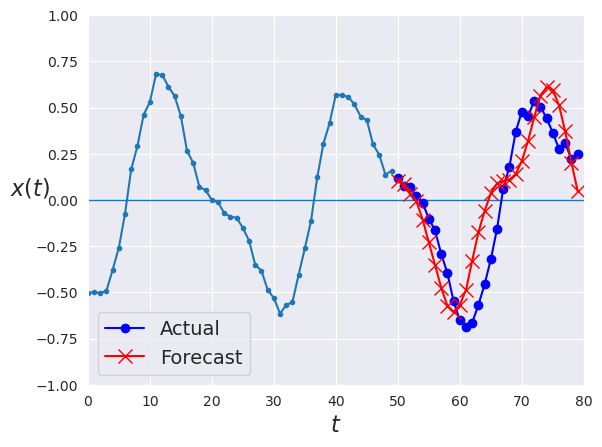

Datos predicción subidas y bajadas
updown [[0.49002421 0.50997579]
 [0.49189344 0.50810653]
 [0.49674809 0.50325191]
 [0.50075793 0.4992421 ]
 [0.51012552 0.48987445]
 [0.52195835 0.47804159]
 [0.53356898 0.46643105]
 [0.54529768 0.45470223]
 [0.55455476 0.44544524]
 [0.55774266 0.44225734]
 [0.55394268 0.44605726]
 [0.54636234 0.45363769]
 [0.53128278 0.46871725]
 [0.51676023 0.48323971]
 [0.50568509 0.49431494]
 [0.49661809 0.50338185]
 [0.49145025 0.50854981]
 [0.49022603 0.50977397]
 [0.48946071 0.51053923]
 [0.48674768 0.51325232]
 [0.47987044 0.52012962]
 [0.46952945 0.53047055]
 [0.45725363 0.54274631]
 [0.44638887 0.55361122]
 [0.44185287 0.55814707]
 [0.44345212 0.55654788]
 [0.45125166 0.54874837]
 [0.4646762  0.5353238 ]
 [0.480766   0.51923394]
 [0.49526933 0.5047307 ]]


In [22]:
# Número de pasos en adelante que vamos a predecir
steps_ahead = 30

series = generate_time_series(1, n_steps + steps_ahead)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

y_pred_one_updown = [[0, 0]]
# repetimos la predicción varias veces
for step_ahead in range(steps_ahead):
    y_pred_one = model.predict(X[:, step_ahead:])
    y_pred_one_amount = y_pred_one[0][:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one_amount], axis=1)
    y_pred_one_updown = np.concatenate([y_pred_one_updown, y_pred_one[1]])
Y_pred = X[:, n_steps:]

def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

print("Datos predicción subidas y bajadas")
print("updown", y_pred_one_updown[1:])


Como podemos ver, el output no enseña pero podemos ver que predicción sale bien. No observamos signos de overfit según datos de entrenamiento.
